### Create a network

Make sure that the proper likelihoods are loading.
Figure out the one thing. 


In [1]:
from fusion.bayes.net import BayesianNetwork

In [2]:
net = BayesianNetwork("carbon")
net.open("/Users/kulwantsaluja/Development/git/constellation/fusion/model/carbon/carbon_v1.0.neta",
             license="+SchragB/DSbox/120,310-6/5894")

INFO:root:Netica 5.04 Linux (AF), (C) 1992-2012 Norsys Software Corp.

The license being used is +SchragB/DSbox/120,310-6/(security part removed).



### Connect to local mongo instance

In [3]:
import pymongo
mongo_database_name = 'neutron'
connection = pymongo.MongoClient('localhost', 27017)
db = connection[mongo_database_name]
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'neutron')

In [4]:
from fusion.model import get_model_json
model_name = 'carbon'
model_version = '1.0'
model_json = get_model_json(model_name, model_version, db)

### Before loading a model, you must always supply a set of DEFAULT likelihoods using function below

In [5]:
from fusion.bayes.bn_json import get_concept_netica_name
from fusion.bayes.bn_json import get_netica_name_from_concept

def get_likelihood_json(model_name, model_version, model_json):
    lh_file_name = '{0}_v{1}_TBLHs.json'.format(model_name, model_version)
    print lh_file_name
    lh_initial = get_file_as_json("fusion.model.{0}".format(model_name), lh_file_name)

    if 'concepts' not in model_json:
        msg = "concepts key does not exist in model_json"
        raise Exception("Problem: {0}".format(msg), sys.exc_info()[2])
        
    lookup = dict()
    for concept in model_json['concepts']:
        concept_netica_name = get_concept_netica_name(concept)
        lookup[concept_netica_name] = get_netica_name_from_concept(concept)
    lh = dict()

    for subject_concept_netica_name, values in lh_initial.iteritems():
        netica_name = lookup[subject_concept_netica_name]
        lh[netica_name] = values[0]
    return lh

### To  call get likelihood, you must get model json, which is a dictionary to pass in.

In [6]:
from fusion.util import get_file_as_json

In [7]:
# net.load_likelihoods()
lh = get_likelihood_json(model_name, model_version, model_json)

carbon_v1.0_TBLHs.json


In [8]:
net.load_likelihoods(lh)

## Final

1. Return only the probability

2. Consolidate code by checking if current node is None.


In [9]:
def load_default_network():
    global net
    global lh
    net.clear()
    net.load_likelihoods(lh)
    
def get_probability_trustworthy(nodes_and_likelihood, hypothesis, current_node=None ):
    global net
    load_default_network()  
   
    for netica_node_name, likelihoods in nodes_and_likelihood.iteritems():
        for likelihood in likelihoods:
            if (current_node != netica_node_name) or (current_node is None)   : # if current_node is None
                net.load_likelihoods({netica_node_name: likelihood })
    d = net.get_prob(name=hypothesis, state_name="true", ndigits=7)
    return d

In [10]:
import pandas as pd
from collections import defaultdict
cursor = db.assets.find({'security.tenant': 'jpmc'})
headings = ['pid', 'netica_node', 'ratio']
df = pd.DataFrame(columns=headings)

for doc in cursor:
    
    pid = doc['pid']
    load_default_network()
    node_and_likelihood = defaultdict(list)
   
    trustworthy_posterior = doc['model_results']['carbon']['results']['Trustworthy']['states']['true']['posterior']
    model_results = doc['model_results']['carbon']['results']
    
    for key, result in model_results.iteritems():
        applied_ingestors =  result['applied_ingestors'] 
        if len(applied_ingestors) > 0:  
            for ingestor in applied_ingestors:   
                netica_node_name = ingestor['netica_node_name']
                likelihood = ingestor['lh'][0]
                node_and_likelihood[netica_node_name].append(likelihood)

    list_netica_node_likelihoods = []
    
    a = get_probability_trustworthy(node_and_likelihood,'Trustworthy_Hyp')
    for current_netica_node in node_and_likelihood:
        b = get_probability_trustworthy(node_and_likelihood, 'Trustworthy_Hyp', current_netica_node)
        list_netica_node_likelihoods.append((b, current_netica_node))
    
    df_temp = pd.DataFrame(columns=headings)
    
      
    for i, result in enumerate(list_netica_node_likelihoods):
        ratio = a/result[0] 
        netica_node = result[1]
        df_temp.loc[i]= [pid, netica_node,ratio]    

    df = pd.concat([df, df_temp], axis=0) 
    print pid,a,trustworthy_posterior
print df 

F732776 0.7336965 0.7336966
M001080 0.6585826 0.6585827
M000417 0.7354684 0.7354686
M000266 0.68196 0.6819602
M000761 0.6504397 0.65044
M000657 0.7887327 0.7887328
M001117 0.6778396 0.6778398
M001103 0.6776061 0.6776066
M000892 0.6727186 0.672718
V773272 0.5328115 0.5328119
M000978 0.6848081 0.6848083
M000321 0.7355977 0.7355977
M001204 0.7347211 0.7347212
M000278 0.6761585 0.6761589
M000267 0.6654164 0.6654168
M000133 0.6057404 0.6057407
M000070 0.7390659 0.7390659
M000712 0.7191423 0.7191427
M000846 0.6507756 0.6507758
M000372 0.7367068 0.7367069
U777448 0.6892861 0.6892864
M000691 0.4051121 0.4051123
M000799 0.5578898 0.5578896
M000860 0.6225991 0.6225992
M000841 0.6689803 0.6689805
M000844 0.6165701 0.6165704
M000777 0.6637568 0.663757
M000647 0.6761013 0.6761009
M000913 0.6754416 0.6754417
M000066 0.6073917 0.6073919
M001196 0.6624329 0.6624333
M000083 0.6680466 0.6680462
M001030 0.6638473 0.6638476
R744777 0.6697381 0.6697384
M000779 0.6238006 0.6238009
M000142 0.54417 0.5441703


array([[<matplotlib.axes.AxesSubplot object at 0x110f88350>,
        <matplotlib.axes.AxesSubplot object at 0x11554b350>]], dtype=object)

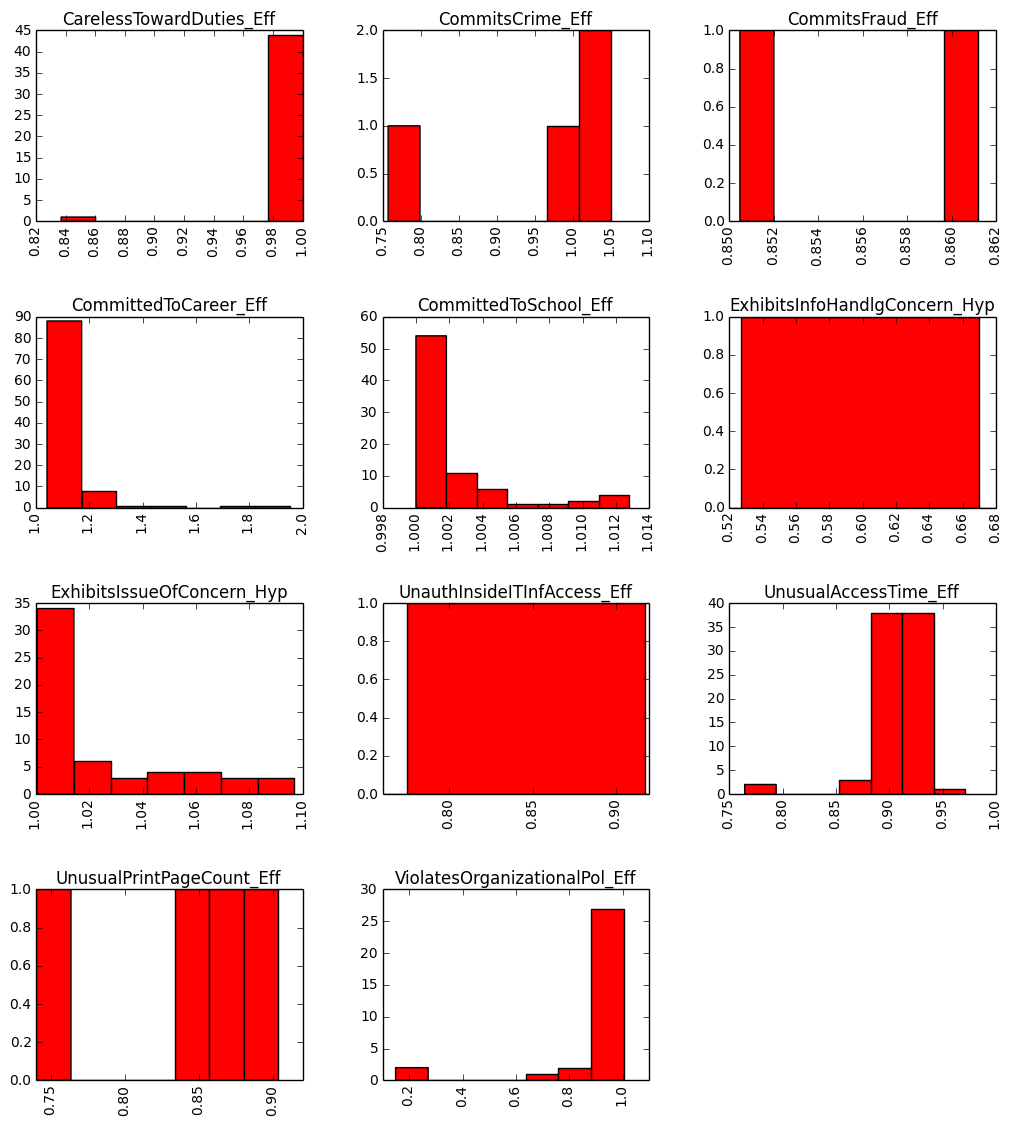

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(by=df['netica_node'],figsize=(12,14),bins=7, color='red')

In [12]:
df.to_csv('top_impacts.csv')

In [13]:
df.index

Int64Index([0, 1, 0, 0, 1, 2, 0, 1, 2, 3,
            ...
            2, 0, 1, 2, 3, 4, 0, 1, 2, 3],
           dtype='int64', length=407)

In [14]:
df.reset_index()


df.drop('index', inplace=True)

In [15]:
df.reset_index

<bound method DataFrame.reset_index of         pid                    netica_node     ratio
0   F732776          CommittedToCareer_Eff  1.113964
1   F732776          CommittedToSchool_Eff  1.000055
0   M001080       CarelessTowardDuties_Eff  0.999968
0   M000417          CommittedToCareer_Eff  1.113807
1   M000417     ExhibitsIssueOfConcern_Hyp  1.002009
2   M000417       CarelessTowardDuties_Eff  1.000000
0   M000266     ExhibitsIssueOfConcern_Hyp  1.008811
1   M000266          CommittedToCareer_Eff  1.137122
2   M000266          CommittedToSchool_Eff  1.000082
3   M000266          UnusualAccessTime_Eff  0.922302
0   M000761     ExhibitsIssueOfConcern_Hyp  1.001999
1   M000761          CommittedToCareer_Eff  1.094205
2   M000761          CommittedToSchool_Eff  1.000000
3   M000761          UnusualAccessTime_Eff  0.914528
0   M000657     ExhibitsIssueOfConcern_Hyp  1.063420
1   M000657          CommittedToCareer_Eff  1.093919
2   M000657          CommittedToSchool_Eff  1.009739
3   M00

In [16]:
df.dtypes

pid             object
netica_node     object
ratio          float64
dtype: object

In [17]:
df.shape

(407, 3)

In [18]:
df['netica_node'].value_counts()

CommittedToCareer_Eff            100
UnusualAccessTime_Eff             82
CommittedToSchool_Eff             79
ExhibitsIssueOfConcern_Hyp        57
CarelessTowardDuties_Eff          45
ViolatesOrganizationalPol_Eff     32
CommitsCrime_Eff                   4
UnusualPrintPageCount_Eff          4
CommitsFraud_Eff                   2
UnauthInsideITInfAccess_Eff        1
ExhibitsInfoHandlgConcern_Hyp      1
Name: netica_node, dtype: int64

In [19]:
df.groupby('netica_node')

In [20]:
df = df[df['ratio'] < 1.0]
g = df.groupby('netica_node')
((1.- g.ratio.mean()) * g.netica_node.count()).sort_values(ascending=False)

netica_node
UnusualAccessTime_Eff            7.536033
ViolatesOrganizationalPol_Eff    3.169204
UnusualPrintPageCount_Eff        0.637750
ExhibitsInfoHandlgConcern_Hyp    0.401372
CommitsFraud_Eff                 0.288345
CommitsCrime_Eff                 0.242780
CarelessTowardDuties_Eff         0.225216
UnauthInsideITInfAccess_Eff      0.153707
dtype: float64